In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = my.connector.connect(host = "your_host",
                          username = "your_username",
                          password = "your_password",
                          database = "your_database")
cur = db.cursor()

# List all unique cities where customers are located

In [2]:
query = """ select distinct(customer_city) from customers"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["city"])
df.head()

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [69]:
query="""SELECT COUNT( order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"""

cur.execute(query)

data=cur.fetchall()
print(" The number of orders placed in 2017 is :",data[0][0])

 The number of orders placed in 2017 is : 45101


#  Find the total sales per category.

In [4]:
query="""select upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


#  Calculate the percentage of orders that were paid in installments.

In [77]:
query="""select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data=cur.fetchall()

print("The percentage of orders that were paid in installments is:",data[0][0])

The percentage of orders that were paid in installments is: 99.9981


# Count the number of customers from each state.

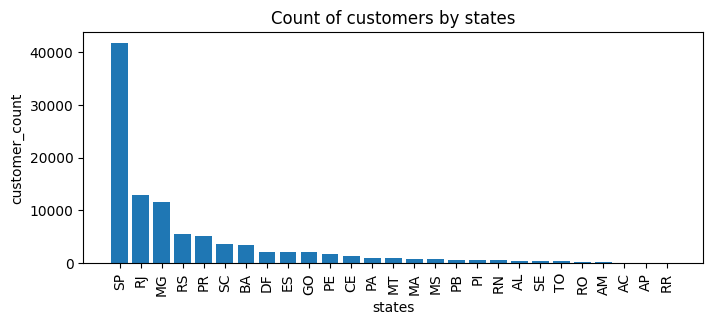

In [6]:
query="""select  customer_state ,count(customer_id) from customers group by customer_state"""

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by ="customer_count",ascending=False)

plt.figure(figsize =(8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation =90)

plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of customers by states")
plt.show()

# Calculate the number of orders per month in 2018


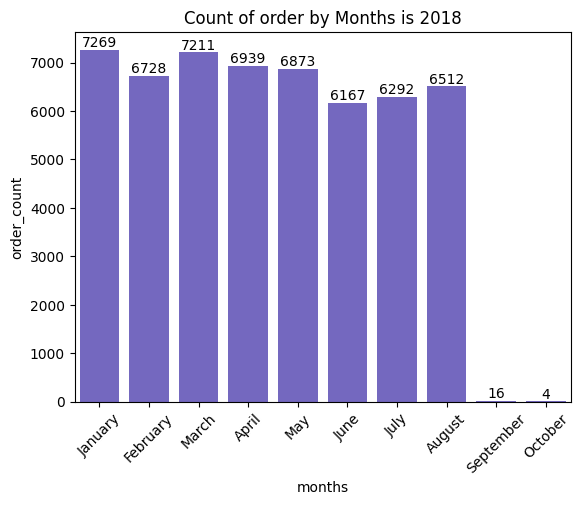

In [86]:
query="""select monthname(order_purchase_timestamp) months, count(order_id) order_count from orders where year(order_purchase_timestamp)=2018 
group by months"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns = ["months","order_count"])

o= ["January","February","March","April","May","June","July","August","September","October"]

ax=sns.barplot(x=df["months"],y=df["order_count"],data= df ,order=o,color="slateblue")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of order by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [78]:
query="""with count_per_order as
(select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer city","average products/order"])
df

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [14]:
query =""" select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Category","Percentage distribution"])
df

,Category,Percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


 # Identify the correlation between product price and the number of times a product has been purchased

In [79]:
query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2) 
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Category","order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print(" The correlation between product price and the number of times a product has been purchased is:",a[0][-1])

 The correlation between product price and the number of times a product has been purchased is: -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

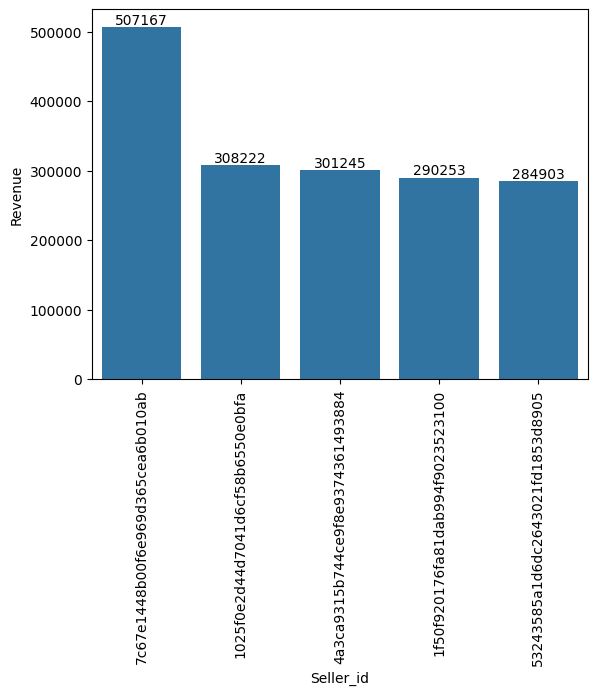

In [29]:
query="""select *,dense_rank() over(order by revenue desc) as rn from
(SELECT order_items.seller_id,round(sum(payments.payment_value),2)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)as a"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller_id","Revenue","Rank"])
df= df.head()
lb=sns.barplot(x = "Seller_id", y= "Revenue", data = df)
plt.xticks(rotation = 90)
lb.bar_label(lb.containers[0])
plt.show()


# Calculate the moving average of order values for each customer over their order history.

In [35]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join  orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer_id","Timestamp","Price","Moving_avg"])
df


,Customer_id,Timestamp,Price,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

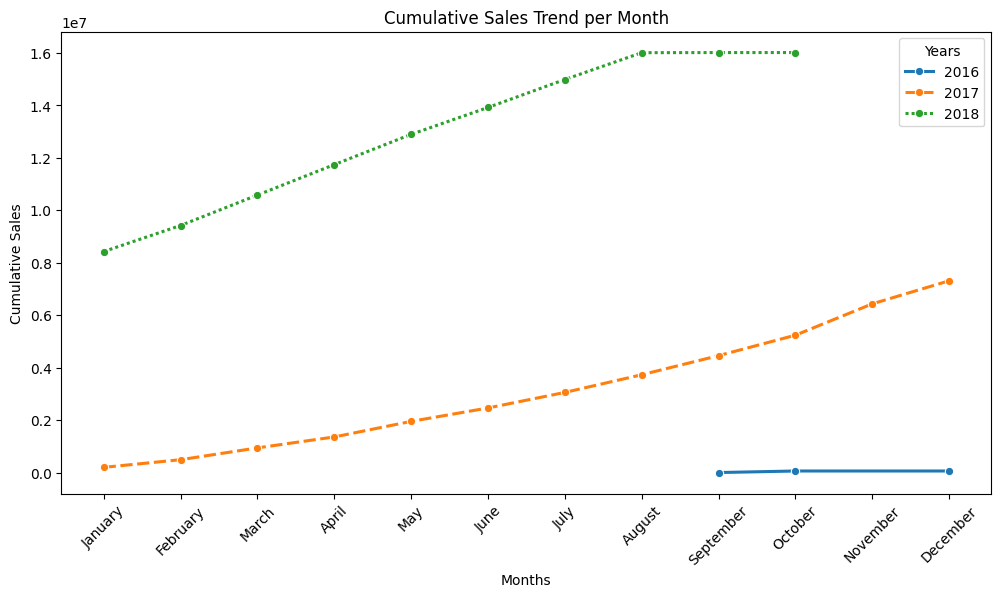

In [50]:
query="""select years,months,payment,round(sum(payment)
over(order by years,months),2) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by  years,months order by years , months) as a"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","Months","Payment","Cumulative Sales"])


o= ["January","February","March","April","May","June","July","August","September","October","November","December"]

plt.figure(figsize=(12,6))

sns.lineplot(
    data=df,
    x="Months",
    y="Cumulative Sales",
    hue="Years",
    marker="o",
    style="Years",
    linewidth=2.2,
    palette="tab10"
)

plt.xticks(range(1,13), o, rotation=45)
plt.title("Cumulative Sales Trend per Month")

plt.show()


# Calculate the year-over-year growth rate of total sales.

In [92]:
query =""" with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by  years order by years)

select years, ((payment - lag(payment,1) over(order by years))/ lag(payment,1) over(order by years))*100 from a
"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","YOY % growth"])
df

,Years,YOY % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [60]:
query ="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id 
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select  100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)

data= cur.fetchall()
print("The retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase is: ",data[0][0])

The retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase is:  None


# Identify the top 3 customers who spent the most money in each year.

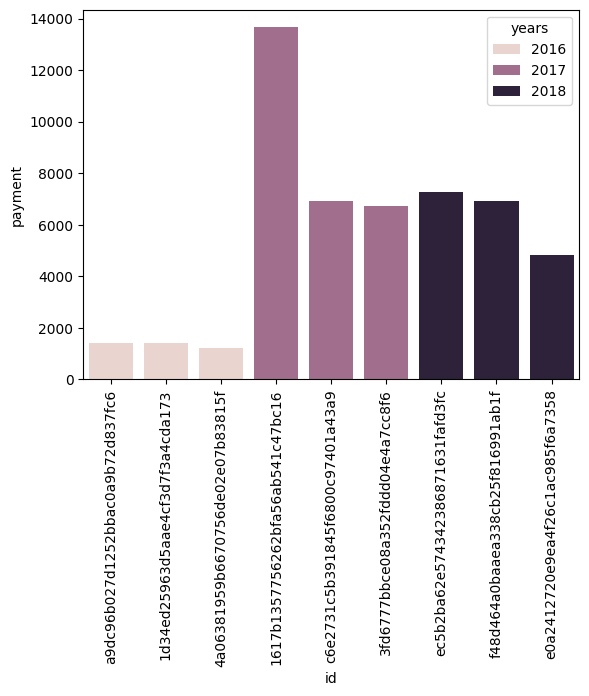

In [67]:
query ="""select years,customer_id,payment,d_rank
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","id","payment","rank"])
sns.barplot(x="id",y="payment",data=df,hue="years")
plt.xticks(rotation=90)
plt.show()